# Resolvendo circuitos resistivos pela Análise Nodal Modificada

Date: 2022-09-23  
Author: Pedro H. N. Vieira  
Categories: circuitos  
Tags: python, circuitos  
<!--eofm-->

## Teoria Base de Circuitos Elétricos

A fundação da teoria de circuitos elétricos consiste da Lei de Ohm
$$
V = R \cdot I,
$$
que relaciona a tensão $V$ sobre um elemento resistivo de valor $R$ com a corrente $I$ passando por ele; e das duas Leis de Kirchhoff.

O valor recíproco da resistência elétrica $R$ é a admitância $Y$, ou seja,
$$
Y = \frac{1}{R}.
$$

A Lei de Kirchhoff das Correntes diz que a soma das correntes entrando um nó do circuito é igual a soma das correntes saindo do mesmo. Em outra palavras, pode-se convencionar que as correntes que entram num nó são positivas e as que saem são negativas, assim, a Lei de Kirchhoff das Correntes pode ser equacionada por:
$$
\sum I_k = 0,
$$
onde $I_k$ é a corrente no elemento $k$ conectado ao nó.

A Lei de Kirchhoff das Tensões enuncia que a soma das tensões numa laço (um caminho fechado) do circuito é zero.
$$
\sum V_k = 0,
$$
onde $V_k$ é a tensão sobre o elemento $k$.

## Análise Nodal

Aplicando-se a Lei de Kirchhoff das Correntes ao nó $n$ de um circuito elétrico composto exclusivamente de resistores e fontes de corrente independentes, obtém-se a seguinte equação
$$
\sum_{k=0}^{N_r} \frac{V_{k+} - V_{k-}}{R_k} = \sum_{f=0}^{N_i} I_f,
$$
onde $N_r$ e $N_i$ são o número de resistores e fontes de corrente conectadas ao nó, respectivamente. Convenciona-se que todo resistor possui um terminal (nó) positivo e um negativo cujos potenciais elétricos são $V_{k+}$ e $V_{k-}$, respectivamente. A equação acima nos diz que a soma das correntes injetadas no nó pelas fontes é igual à soma das correntes nos resistores.

Repetindo-se o procedimento acima para todos os $N_n$ nós do circuito, obtém-se $N_n$ equações lineares que são linearmente dependentes. Para garantir a unicidade da solução (um sistema linearmente independente), escolhe-se um nó para ser o Terra (o potencial elétrico nele é arbitrado como zero) e a equação correspondente a ele é descartada. O sistema linear resultante é
$$
[Y] \cdot [V] = [I]
$$
onde $[Y]$ é a matriz (simétrica) de admitâncias nodais, $[V]$ é o vetor de potenciais nodais e $[I]$ é o vetor de correntes injetadas nos nós.

Convencionando que cada nó possui uma numeração (índice) positivo, atribuindo-se o índice 0 ao nó Terra, o seguinte algorítimo permite construir o sistema linear elemento a elemento do circuito. Dizemos que cada elemento se "carimba" no sistema linear.

```
Y := matriz de admitâncias
I := vetor de correntes injetadas
Para cada elemento E:
  no1 := nó positivo de E
  no2 := nó negativo de E
  se E é um resistor:
    r := resistência de E
    Y[no1, no2] = Y[no1, no2] - 1 / r
    Y[no2, no1] = Y[no1, no2]
    Y[no1, no1] = Y[no1, no1] + 1 / r
    Y[no2, no2] = Y[no2, no2] + 1 / r
    
   se E é uma fonte de corrente:
     i := valor da fonte E
     I[no1] = I[no1] + i
     I[no2] = I[no2] - i

Descartam-se a linha e a coluna de índice 0 da matriz Y
Descarta-se o valor de índice 0 do vetor I
```

## Código

Importam-se alguns módulos (bibliotecas).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm

Define-se a classe de objetos `Elemento` básicos do circuito, os quais são inicializados (construídos) por `Elemento(no1, no2, valor, nome)`. O valor `nome` do elemento é opicional e será vazio se não atribuído. A partir deste `Elemento`, definem-se as classes de objetos `Resistor` e `Fonte_Corrente` que herdam todos os métodos e atributos de `Elemento` (conceitos de [Programação Orientada a Objetos](https://pt.wikipedia.org/wiki/Programação_orientada_a_objetos)), cada qual redefine a forma que se carimbam, através do método `carimbar`, no sistema linear. Há testes `se, então` para ignorar o nó Terra (0) na construção do sistema linear.

In [2]:
class Elemento(object):
    def __init__(self, no1, no2, valor, nome=""):  # esse é o construtor do objeto
        if no1 < 0 or no2 < 0:
            raise ValueError("O nó deve ser um valor não negativo.")
            
        self.no1 = no1
        self.no2 = no2
        self.valor = valor
        self.nome = nome
      
    
    def __repr__(self):  # esse é o "print" do objeto
        s = "Elemento " + self.nome + " de valor " + str(self.valor)
        s += " do nó " + str(self.no1) + " para o nó " + str(self.no2)
        return s
    
    
    def carimbar(self, Y, I, nn):
        return None
        

class Resistor(Elemento):
    def __init__(self, no1, no2, valor, nome=""):
        if valor <= 0.0:
            raise ValueError("Resistor deve ter um valor positivo.")
            
        super().__init__(no1, no2, valor, nome)
       
    
    def carimbar(self, Y, I=None, nn=None):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        admitancia = 1.0 / self.valor
        if no1 >= 0:
            Y[no1, no1] += admitancia
            
        if no2 >= 0:
            Y[no2, no2] += admitancia
            
        if no1 >= 0 and no2 >= 0:
            Y[no1, no2] += -admitancia
            Y[no2, no1] = Y[no1, no2]
        
        
class Fonte_Corrente(Elemento):
    def __init__(self, no1, no2, valor, nome=""):
        super().__init__(no1, no2, valor, nome)
        
    
    def carimbar(self, Y, I, nn=None):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        if no1 >= 0:
            I[no1] += -self.valor
            
        if no2 >= 0:
            I[no2] += self.valor

A função abaixo identifica quantos nós há no circuito a partir da lista de elementos `netlist` e retorna o índice do maior nó.

In [3]:
def maior_no(netlist):
    m = 0
    for elemento in netlist:
        if elemento.no1 > m:
            m = elemento.no1
            
        if elemento.no2 > m:
            m = elemento.no2
    
    return m

Usamos o módulo [SchemDraw](https://schemdraw.readthedocs.io/en/latest/index.html) para desenhar um circuito. O número (índice) dos nós são os números em parênteses e estão indicados, para cada elemento, qual nó é arbitrado como o positivo e o negativo para ele. A convenção adotada é de que todas as correntes nos elementos fluem do nó positivo para o negativo.

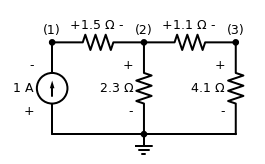

In [4]:
with schemdraw.Drawing() as d:
    d += (I := elm.SourceI().up().label(('+', '1 A', '-')))
    d += (R1 := elm.Resistor().right().label(('+', '1.5 Ω', '-')))
    d += (R2 := elm.Resistor().right().label(('+', '1.1 Ω', '-')))
    d += (R3 := elm.Resistor().down().label(('+', '4.1 Ω', '-')))
    d += elm.Line().left()
    d += (R4 := elm.Resistor().up().label(('-', '2.3 Ω', '+')))
    d += elm.Line().endpoints(I.start, R4.start)
    d += elm.Ground()
    d += elm.Dot().at(R1.start).label("(1)")
    d += elm.Dot().at(R1.end).label("(2)")
    d += elm.Dot().at(R2.end).label("(3)")
    d += elm.Dot().at(R4.start)

Criamos a lista de elementos `netlist`, criamos uma matriz `Y` e um vetor `I` de zeros e, então, iteramos cada elemento na `netlist` para montar o sistema linear

In [5]:
netlist = [
    Fonte_Corrente(0, 1, 1.0),
    Resistor(1, 2, 1.5),
    Resistor(2, 3, 1.1),
    Resistor(2, 0, 2.3),
    Resistor(3, 0, 4.1),
    
]
n = maior_no(netlist)
Y = np.zeros((n,n))
I = np.zeros((n,))
for elemento in netlist:
    elemento.carimbar(Y, I)
    
V = np.linalg.solve(Y, I)
for i in range(n):
    print("Potencial no nó" + str(i+1) + ":", round(V[i], 2), "V")

Potencial no nó1: 3.09 V
Potencial no nó2: 1.59 V
Potencial no nó3: 1.26 V


## Análise Nodal Modificada

Quando o circuito tem uma fonte de tensão, ideal e independente, a análise nodal não consegue tratá-la. Por isso, é necessário, para cada fonte de tensão $V_f$, adicionar mais uma equação ao sistema linear e tratar a corrente na fonte como uma variável. A nova equação é da forma
$$
V_{k+} - V_{k-} = V_f.
$$

Assim sendo, o algoritimo para "carimbar" o sistema linear ampliado com fontes de tensão é:
```
nn := número de nós no sistema
nv := número de fontes de tensão
Y := matriz quadrada de admitâncias ampliada cuja ordem é (nn + nv)
I := vetor de correntes injetadas concatenado com
     o vetor de fontes de tensão, cuja dimensão é dimensão (nn + nv)
Para cada elemento E:
  no1 := nó positivo de E
  no2 := nó negativo de E
  se E é um resistor:
    r := resistência de E
    Y[no1, no2] = Y[no1, no2] - 1 / r
    Y[no2, no1] = Y[no1, no2]
    Y[no1, no1] = Y[no1, no1] + 1 / r
    Y[no2, no2] = Y[no2, no2] + 1 / r
    
   se E é uma fonte de corrente:
     i := valor da fonte E
     I[no1] = I[no1] + i
     I[no2] = I[no2] - i

   se E é uma fonte de tensão:
     v := valor da fonte E
     e := índice da fonte E
     Y[no1, (nn - 1 + e)] = -1
     Y[no2, (nn - 1 + e)] = 1
     Y[(nn - 1 + e), no1] = 1
     Y[(nn - 1 + e), no2] = -1
     I[(nn - 1 + e)] = v
     
Descartam-se a linha e a coluna de índice 0 da matriz Y
Descarta-se o valor de índice 0 do vetor I
```

Definimos a seguir a classe de objetos `Fonte_Tensao`. É necessário, para montar o sistema linear, dar um índice único a cada fonte de tensão.

In [6]:
class Fonte_Tensao(Elemento):
    def __init__(self, no1, no2, valor, indice, nome=""):
        if indice < 1:
            raise ValueError("indice deve ser um valor positivo.")
            
        super().__init__(no1, no2, valor, nome)
        self.indice = indice
        
    
    def carimbar(self, Y, I, nn):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        e = self.indice
        I[(nn - 1 + e)] = self.valor
        if no1 >= 0:
            Y[no1, (nn - 1 + e)] = -1
            Y[(nn - 1 + e), no1] = 1
            
        if no2 >= 0:
            Y[no2, (nn - 1 + e)] = 1
            Y[(nn - 1 + e), no2] = -1
            
        if no1 >= 0 and no2 >= 0:
            Y[id1, id2] += -1
            Y[id2, id1] = Y[id1, id2]

Vamos substituir a fonte de corrente do exemplo anterior por uma fonte de tensão e resolver o circuito.

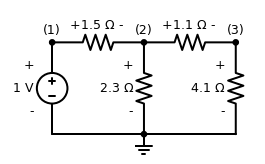

In [7]:
with schemdraw.Drawing() as d:
    d += (I := elm.SourceV().up().label(('-', '1 V', '+')))
    d += (R1 := elm.Resistor().right().label(('+', '1.5 Ω', '-')))
    d += (R2 := elm.Resistor().right().label(('+', '1.1 Ω', '-')))
    d += (R3 := elm.Resistor().down().label(('+', '4.1 Ω', '-')))
    d += elm.Line().left()
    d += (R4 := elm.Resistor().up().label(('-', '2.3 Ω', '+')))
    d += elm.Line().endpoints(I.start, R4.start)
    d += elm.Ground()
    d += elm.Dot().at(R1.start).label("(1)")
    d += elm.Dot().at(R1.end).label("(2)")
    d += elm.Dot().at(R2.end).label("(3)")
    d += elm.Dot().at(R4.start)

In [8]:
netlist = [
    Fonte_Tensao(1, 0, 1.0, 1),
    Resistor(1, 2, 1.5),
    Resistor(2, 3, 1.1),
    Resistor(2, 0, 2.3),
    Resistor(3, 0, 4.1),
    
]
nn = maior_no(netlist)
nv = 1  # número de fontes de tensão
m = nv + nn
Y = np.zeros((m, m))
I = np.zeros((m,))
for elemento in netlist:
    elemento.carimbar(Y, I, nn)
    
V = np.linalg.solve(Y, I)
for i in range(nn):
    print("Potencial no nó" + str(i+1) + ":", round(V[i], 2), "V")
    
for i in range(nv):
    print("Corrente na fonte de tensão " + str(i+1) + ":", round(V[nn + nv - 1], 2), "A")

Potencial no nó1: 1.0 V
Potencial no nó2: 0.52 V
Potencial no nó3: 0.41 V
Corrente na fonte de tensão 1: 0.32 A


## Considerações finais

Para circuitos que variam no tempo, com elementos não resistivos (capacitores, indutores, diodos, etc) ou fontes dependentes, estes elementos são sintetizados, a cada passo no tempo, num circuito resistivo equivalente que depende do método de integração numérica adotado e dos valores obtidos no passo de tempo anterior. Os detalhes de como fazer isto serão deixados para um *post* no futuro.

# Referências

<a name="1"></a>[1] NAJM, Farid N. **Circuit simulation**. John Wiley & Sons, 2010.